In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.metrics import log_loss
from sklearn.metrics import average_precision_score as aps
from sklearn.metrics import roc_auc_score as auc

import lightgbm as lgb

In [3]:
df = pd.read_csv('train.csv')

In [4]:
df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [5]:
feature_list = list(df.columns)
feature_list.remove('ID_code')
feature_list.remove('target')

X = df[feature_list].values
y = df['target'].values

In [6]:
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size = 0.3)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size = 0.2)

In [8]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

lgbm_params = {
    'objective': 'binary',
    'is_unbalance': True,
    'num_leaves': 24,
}

# 上記のパラメータでモデルを学習する
model = lgb.train(lgbm_params, lgb_train, valid_sets=lgb_val, num_boost_round=1000)

[1]	valid_0's binary_logloss: 0.324608
[2]	valid_0's binary_logloss: 0.335977
[3]	valid_0's binary_logloss: 0.35047
[4]	valid_0's binary_logloss: 0.36612
[5]	valid_0's binary_logloss: 0.381138
[6]	valid_0's binary_logloss: 0.396324
[7]	valid_0's binary_logloss: 0.410528
[8]	valid_0's binary_logloss: 0.42399
[9]	valid_0's binary_logloss: 0.436704
[10]	valid_0's binary_logloss: 0.448366
[11]	valid_0's binary_logloss: 0.458198
[12]	valid_0's binary_logloss: 0.467773
[13]	valid_0's binary_logloss: 0.476268
[14]	valid_0's binary_logloss: 0.484206
[15]	valid_0's binary_logloss: 0.490756
[16]	valid_0's binary_logloss: 0.496867
[17]	valid_0's binary_logloss: 0.502172
[18]	valid_0's binary_logloss: 0.50697
[19]	valid_0's binary_logloss: 0.510978
[20]	valid_0's binary_logloss: 0.514229
[21]	valid_0's binary_logloss: 0.516699
[22]	valid_0's binary_logloss: 0.51962
[23]	valid_0's binary_logloss: 0.52203
[24]	valid_0's binary_logloss: 0.523758
[25]	valid_0's binary_logloss: 0.525198
[26]	valid_0's 

[205]	valid_0's binary_logloss: 0.373703
[206]	valid_0's binary_logloss: 0.373171
[207]	valid_0's binary_logloss: 0.372755
[208]	valid_0's binary_logloss: 0.372282
[209]	valid_0's binary_logloss: 0.371784
[210]	valid_0's binary_logloss: 0.371313
[211]	valid_0's binary_logloss: 0.370874
[212]	valid_0's binary_logloss: 0.370466
[213]	valid_0's binary_logloss: 0.370038
[214]	valid_0's binary_logloss: 0.369595
[215]	valid_0's binary_logloss: 0.369124
[216]	valid_0's binary_logloss: 0.368717
[217]	valid_0's binary_logloss: 0.368186
[218]	valid_0's binary_logloss: 0.367818
[219]	valid_0's binary_logloss: 0.367394
[220]	valid_0's binary_logloss: 0.366997
[221]	valid_0's binary_logloss: 0.366594
[222]	valid_0's binary_logloss: 0.366268
[223]	valid_0's binary_logloss: 0.365867
[224]	valid_0's binary_logloss: 0.365483
[225]	valid_0's binary_logloss: 0.365086
[226]	valid_0's binary_logloss: 0.364678
[227]	valid_0's binary_logloss: 0.364324
[228]	valid_0's binary_logloss: 0.363921
[229]	valid_0's 

[406]	valid_0's binary_logloss: 0.31629
[407]	valid_0's binary_logloss: 0.316124
[408]	valid_0's binary_logloss: 0.315877
[409]	valid_0's binary_logloss: 0.315667
[410]	valid_0's binary_logloss: 0.315514
[411]	valid_0's binary_logloss: 0.315294
[412]	valid_0's binary_logloss: 0.315106
[413]	valid_0's binary_logloss: 0.31491
[414]	valid_0's binary_logloss: 0.314698
[415]	valid_0's binary_logloss: 0.314598
[416]	valid_0's binary_logloss: 0.314452
[417]	valid_0's binary_logloss: 0.314292
[418]	valid_0's binary_logloss: 0.314153
[419]	valid_0's binary_logloss: 0.313989
[420]	valid_0's binary_logloss: 0.313775
[421]	valid_0's binary_logloss: 0.313676
[422]	valid_0's binary_logloss: 0.313516
[423]	valid_0's binary_logloss: 0.313366
[424]	valid_0's binary_logloss: 0.313225
[425]	valid_0's binary_logloss: 0.313049
[426]	valid_0's binary_logloss: 0.312902
[427]	valid_0's binary_logloss: 0.312735
[428]	valid_0's binary_logloss: 0.31256
[429]	valid_0's binary_logloss: 0.31243
[430]	valid_0's bina

[607]	valid_0's binary_logloss: 0.288656
[608]	valid_0's binary_logloss: 0.28857
[609]	valid_0's binary_logloss: 0.288468
[610]	valid_0's binary_logloss: 0.288342
[611]	valid_0's binary_logloss: 0.28822
[612]	valid_0's binary_logloss: 0.288053
[613]	valid_0's binary_logloss: 0.287952
[614]	valid_0's binary_logloss: 0.287765
[615]	valid_0's binary_logloss: 0.287674
[616]	valid_0's binary_logloss: 0.287535
[617]	valid_0's binary_logloss: 0.287466
[618]	valid_0's binary_logloss: 0.287334
[619]	valid_0's binary_logloss: 0.287174
[620]	valid_0's binary_logloss: 0.287021
[621]	valid_0's binary_logloss: 0.286937
[622]	valid_0's binary_logloss: 0.286803
[623]	valid_0's binary_logloss: 0.286771
[624]	valid_0's binary_logloss: 0.286687
[625]	valid_0's binary_logloss: 0.286505
[626]	valid_0's binary_logloss: 0.286384
[627]	valid_0's binary_logloss: 0.286197
[628]	valid_0's binary_logloss: 0.286078
[629]	valid_0's binary_logloss: 0.28593
[630]	valid_0's binary_logloss: 0.28585
[631]	valid_0's bina

[809]	valid_0's binary_logloss: 0.269862
[810]	valid_0's binary_logloss: 0.269749
[811]	valid_0's binary_logloss: 0.269699
[812]	valid_0's binary_logloss: 0.269582
[813]	valid_0's binary_logloss: 0.26953
[814]	valid_0's binary_logloss: 0.269457
[815]	valid_0's binary_logloss: 0.269347
[816]	valid_0's binary_logloss: 0.269292
[817]	valid_0's binary_logloss: 0.269267
[818]	valid_0's binary_logloss: 0.269205
[819]	valid_0's binary_logloss: 0.269119
[820]	valid_0's binary_logloss: 0.269056
[821]	valid_0's binary_logloss: 0.268977
[822]	valid_0's binary_logloss: 0.268934
[823]	valid_0's binary_logloss: 0.268878
[824]	valid_0's binary_logloss: 0.268768
[825]	valid_0's binary_logloss: 0.268658
[826]	valid_0's binary_logloss: 0.268543
[827]	valid_0's binary_logloss: 0.268477
[828]	valid_0's binary_logloss: 0.268379
[829]	valid_0's binary_logloss: 0.268283
[830]	valid_0's binary_logloss: 0.268222
[831]	valid_0's binary_logloss: 0.268148
[832]	valid_0's binary_logloss: 0.268086
[833]	valid_0's b

In [9]:
ctr_train = np.array(y_train).mean()

In [10]:
# テストデータを予測する
def evals(X, y_true, ctr_train):
    y_pred = model.predict(X)
    y_pred_post = y_pred / (y_pred  +  (1 - ctr_train) / ctr_train  * (1 - y_pred) )
    print('logloss: %.4f' % log_loss(y_true, y_pred))
    print('logloss_post: %.4f' % log_loss(y_true, y_pred_post))
    print('auc: %.4f' % auc(y_true, y_pred))
    print('norm aps:  %.4f' % (aps(y_true, y_pred)/y_true.mean()))

In [11]:
print('-'*10)
evals(X_train, y_train, ctr_train)
print('-'*10)
evals(X_val, y_val, ctr_train)
print('-'*10)
evals(X_test, y_test, ctr_train)

----------
logloss: 0.1224
logloss_post: 0.0825
auc: 0.9997
norm aps:  9.9284
----------
logloss: 0.2565
logloss_post: 0.2498
auc: 0.8815
norm aps:  5.5763
----------
logloss: 0.2609
logloss_post: 0.2607
auc: 0.8744
norm aps:  5.3415


In [12]:
def gen_plot_points(X, y_true, num_points=100):
    y_pred = model.predict(X) 
    scores = []
    ctrs = []
    delta = 1 / num_points
    for i in range(num_points):
        mask = (y_pred >= delta * i) * (y_pred < delta * (i +1))
        if mask.sum() > 0:
            scores.append(y_pred[mask].mean())
            ctrs.append(y_true[mask].mean())
    return scores, ctrs

In [13]:
scores_train, ctrs_train  =  gen_plot_points(X_train, y_train)
scores_val, ctrs_val  =  gen_plot_points(X_val, y_val)
scores_test, ctrs_test  =  gen_plot_points(X_test, y_test)

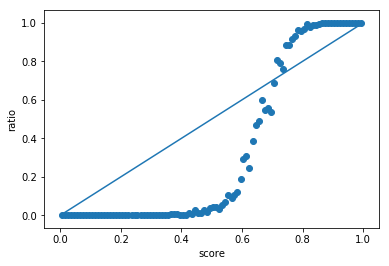

In [20]:
plt.scatter(scores_train, ctrs_train)
plt.plot([0,1], [0,1])
plt.xlabel('score')
plt.ylabel('ratio')
plt.show()

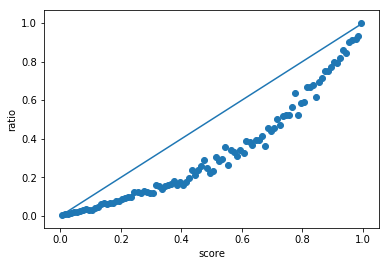

In [21]:
plt.scatter(scores_test, ctrs_test)
plt.plot([0,1], [0,1])
plt.xlabel('score')
plt.ylabel('ratio')
plt.show()

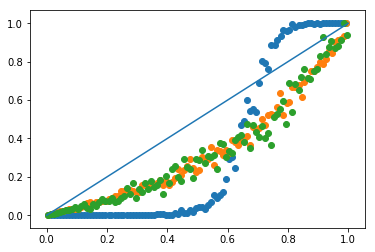

In [14]:
plt.scatter(scores_train, ctrs_train)
plt.scatter(scores_test, ctrs_test)
plt.scatter(scores_val, ctrs_val )

plt.plot([0,1], [0,1])
plt.show()

In [25]:
y_train == 0

array([ True,  True,  True, ...,  True, False,  True])

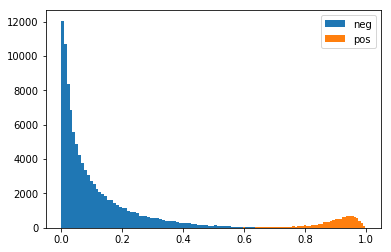

In [28]:
plt.hist(model.predict(X_train[y_train==0]) , bins=100, label='neg')
plt.hist(model.predict(X_train[y_train==1]) , bins=100, label='pos')
plt.legend()
plt.show()

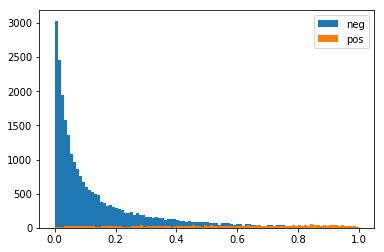

In [29]:
plt.hist(model.predict(X_val[y_val==0]) , bins=100, label='neg')
plt.hist(model.predict(X_val[y_val==1]) , bins=100, label='pos')
plt.legend()
plt.show()

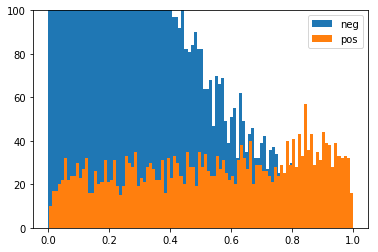

In [31]:
plt.hist(model.predict(X_val[y_val==0]) , bins=100, label='neg')
plt.hist(model.predict(X_val[y_val==1]) , bins=100, label='pos')
plt.ylim(0, 100)
plt.legend()
plt.show()

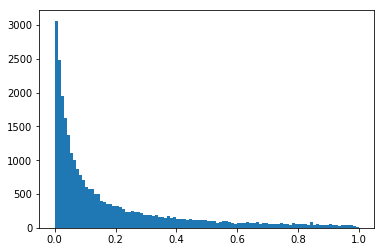

In [23]:
plt.hist(model.predict(X_val) , bins=100)
plt.show()

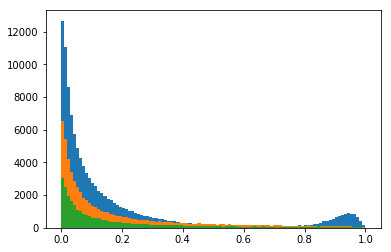

In [15]:
plt.hist(model.predict(X_train) , bins=100)
plt.hist(model.predict(X_test) , bins=100)
plt.hist(model.predict(X_val) , bins=100)
plt.show()

In [16]:
def post(scores, ctr_train):
    s_prev = np.array(scores)
    return s_prev / (s_prev  +  (1 - ctr_train) / ctr_train  * (1 - s_prev) )

In [17]:
s_post_train = post(scores_train, ctr_train)
s_post_val = post(scores_val, ctr_train)
s_post_test = post(scores_test, ctr_train)

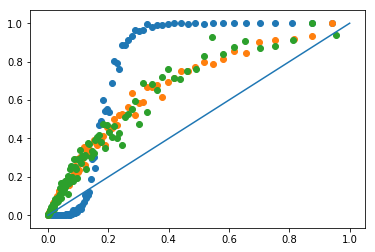

In [18]:
plt.scatter(s_post_train, ctrs_train)
plt.scatter(s_post_test, ctrs_test)
plt.scatter(s_post_val, ctrs_val )

plt.plot([0,1], [0,1])
plt.show()